# Итоговое задание по Проекту 4. Компьютер говорит «Нет»
# ЮНИТ 5. ОСНОВНЫЕ АЛГОРИТМЫ МАШИННОГО ОБУЧЕНИЯ. ЧАСТЬ 1

# 1. Импорт библиотек и подготовка необходимых функций

In [460]:

from pandas import Series
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn import metrics

import datetime as DT


from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_curve 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


In [461]:
# функция для анализа категориальных и номинативных переменных
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='default', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [462]:
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 2. Импорт данных

In [463]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [464]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [465]:
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head())
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head())

Размерность тренировочного датасета:  (73799, 20)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


Размерность тестового датасета:  (36349, 20)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [466]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

# Описание содержимого

1. client_id - идентификатор клиента

2. education - уровень образования

3. sex - пол заемщика

4. age - возраст заемщика

5. car - флаг наличия автомобиля

6. car_type - флаг автомобиля иномарки

7. decline_app_cnt - количество отказанных прошлых заявок

8. good_work - флаг наличия “хорошей” работы

9. bki_request_cnt - количество запросов в БКИ

10. home_address - категоризатор домашнего адреса

11. work_address - категоризатор рабочего адреса

12. income - доход заемщика

13. foreign_passport - наличие загранпаспорта

14. sna - связь заемщика с клиентами банка

15. first_time - давность наличия информации о заемщике

16. score_bki - скоринговый балл по данным из БКИ

17. region_rating - рейтинг региона

18. app_date - дата подачи заявки

19. default - флаг дефолта по кредиту

# 3. Предварительный анализ данных

In [467]:
print(f'Всего в датасете {data.isnull().any().sum()} столбцов с пропущенными значениями.')
# посчитаем сколько колонок с пропущенными значениями

Всего в датасете 1 столбцов с пропущенными значениями.


In [468]:
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

В тренировочном датасете 73799 строк, в тестовом - 36349. В общей сложности представлены данные о 110 148 клиентах. Всего 19 предикторов, из них 1 - временной ряд, 6 бинарных, 7 категориальных и 5 числовых. Всего пропусков 478 (или 0,43 % от общего количества строк), все пропуски в переменной education.

Первое, что сделал - это удалил все колонки с нечисловыми значениями и попробовал запустить модель (model = LogisticRegression()). Score - 0.68488. Будем считать это отправной точкой.

In [469]:
data.default.value_counts(normalize=True)

0    0.914914
1    0.085086
Name: default, dtype: float64

Но в целом, учитывая несбалансированность выборки можно попробовать всегда говорить, что клиент вернет деньги и мы будем правы в 90 процентах случаев.

In [470]:
# Действие относится к самой простой модели, для которой данные вообще не обрабатывались! 
# data.drop(['app_date', 'education', 'sex','car','score_bki', 'car_type', 'good_work', 'foreign_passport'], axis='columns', inplace=True)

In [471]:
# внесем данные из резюме в списки 
# временной ряд (1)
time_cols = ['app_date']
# бинарные переменные (default не включаем в список) (5+1 = 6)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные (sample не включаем в список, так как мы сами его добавили) (7)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные, client_id исключили из списка (5)
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']

# Обработка признаков

# 1. education

In [472]:
data['education'].value_counts(dropna = False)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

478 отсутвтвующих значения. Откуда они взялись - неизвестно, но полагаю, что люди без какого-либо вообще образования вряд-ли обращались за кредитом, поэтому попоробуем заполнить пропуски. Но, чтобы не заполнять их самым простым способом (самое распространенное значение) попробуем выявить некие взаимосвязи.

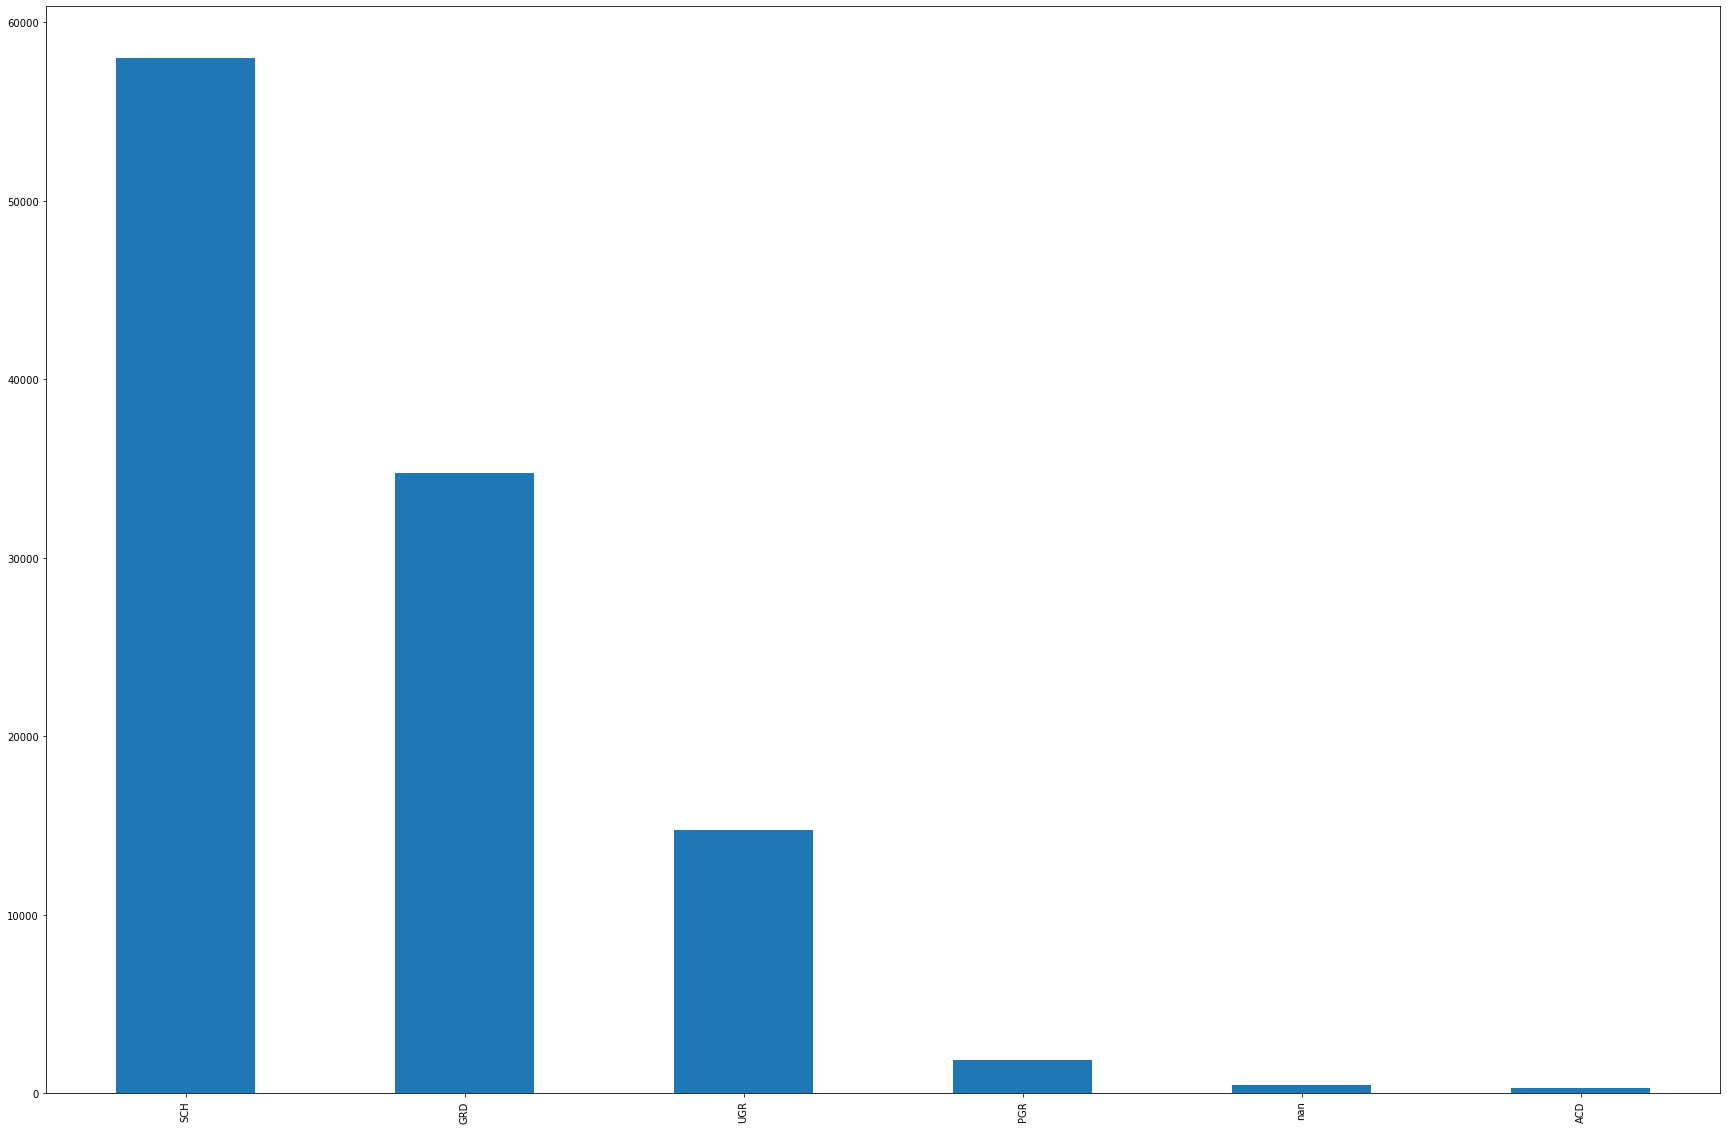

In [473]:
# Визуализируем данные в столбце "education"
data['education'].value_counts(dropna = False).plot.bar()

Наибольшее количество клиентов имеет школьное образование. 

Визуализация взаимосвязи образования и значения нашей целевой переменной.

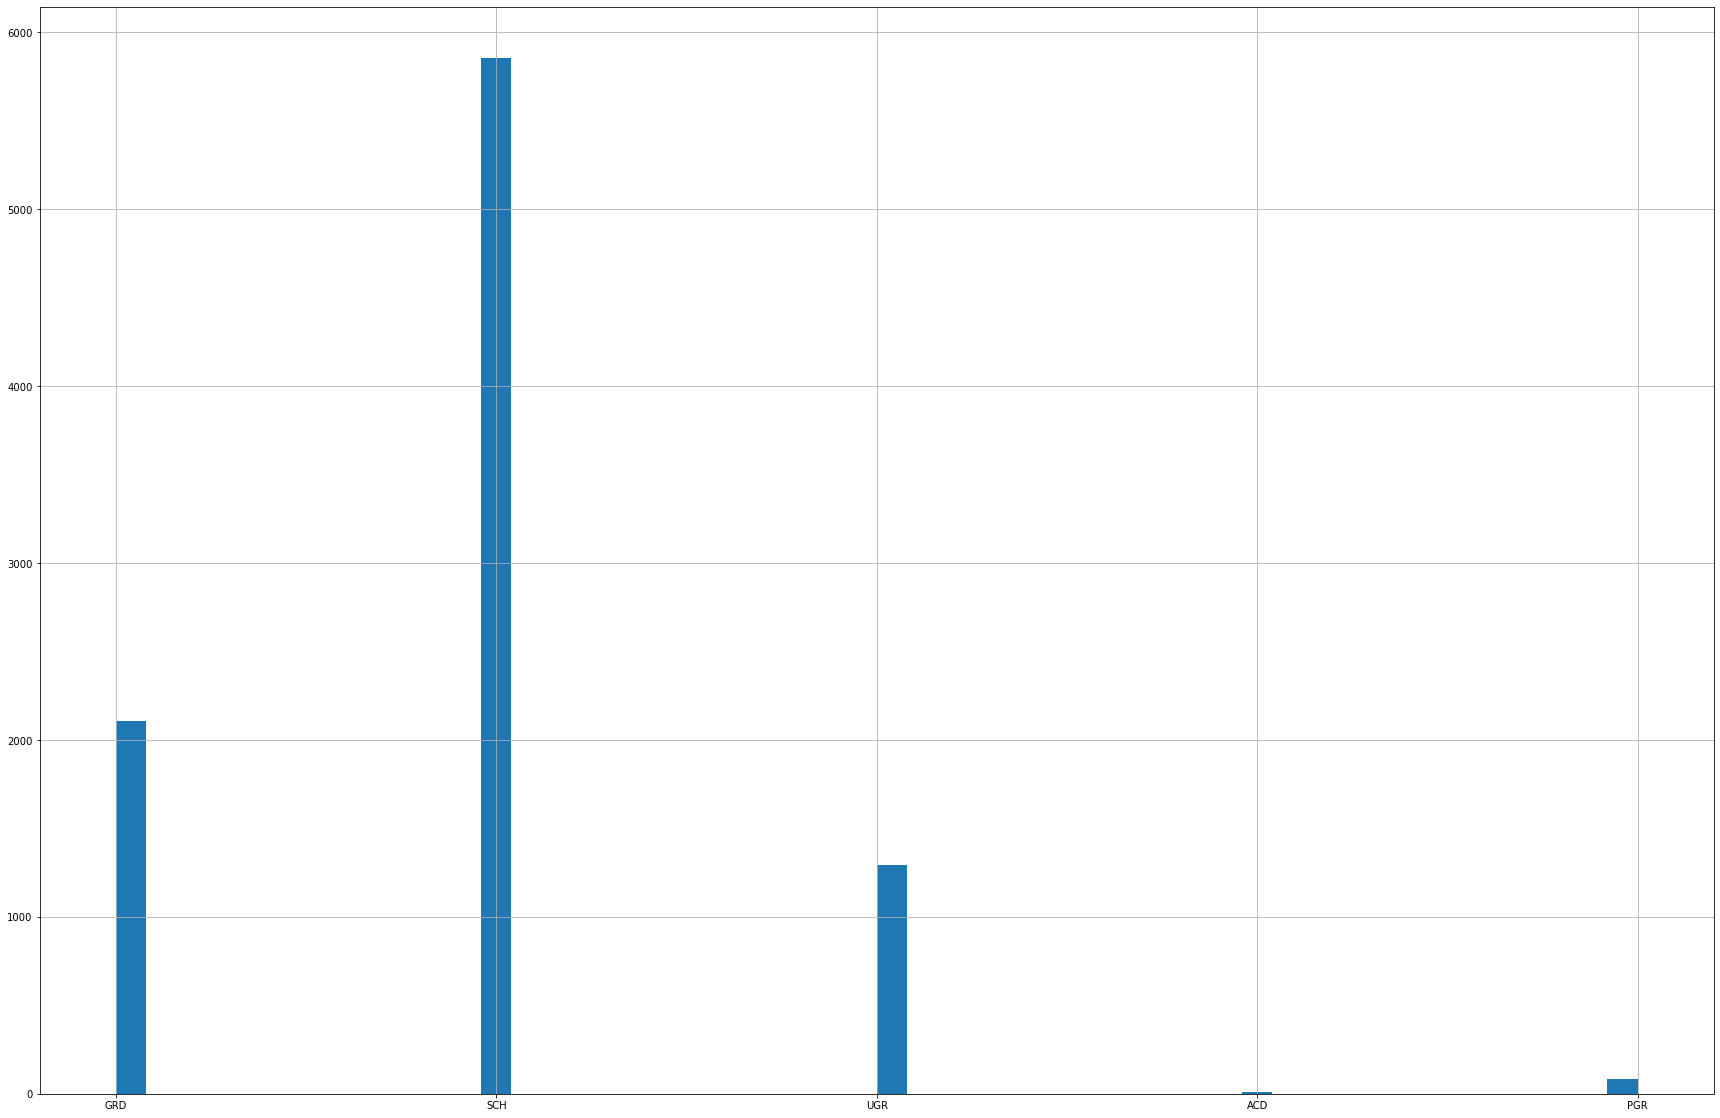

In [474]:
data['education'][data['default'] == 1].hist(bins=50)

Ничего удивительного не обнаружилось, ввиду того, что наиболее распространенным значением является SCH, соответственно наиболее частые дефолты по кредитам встречаются именно с этой категорией клиентов.

Взаимосвязь образования и пола клиента.

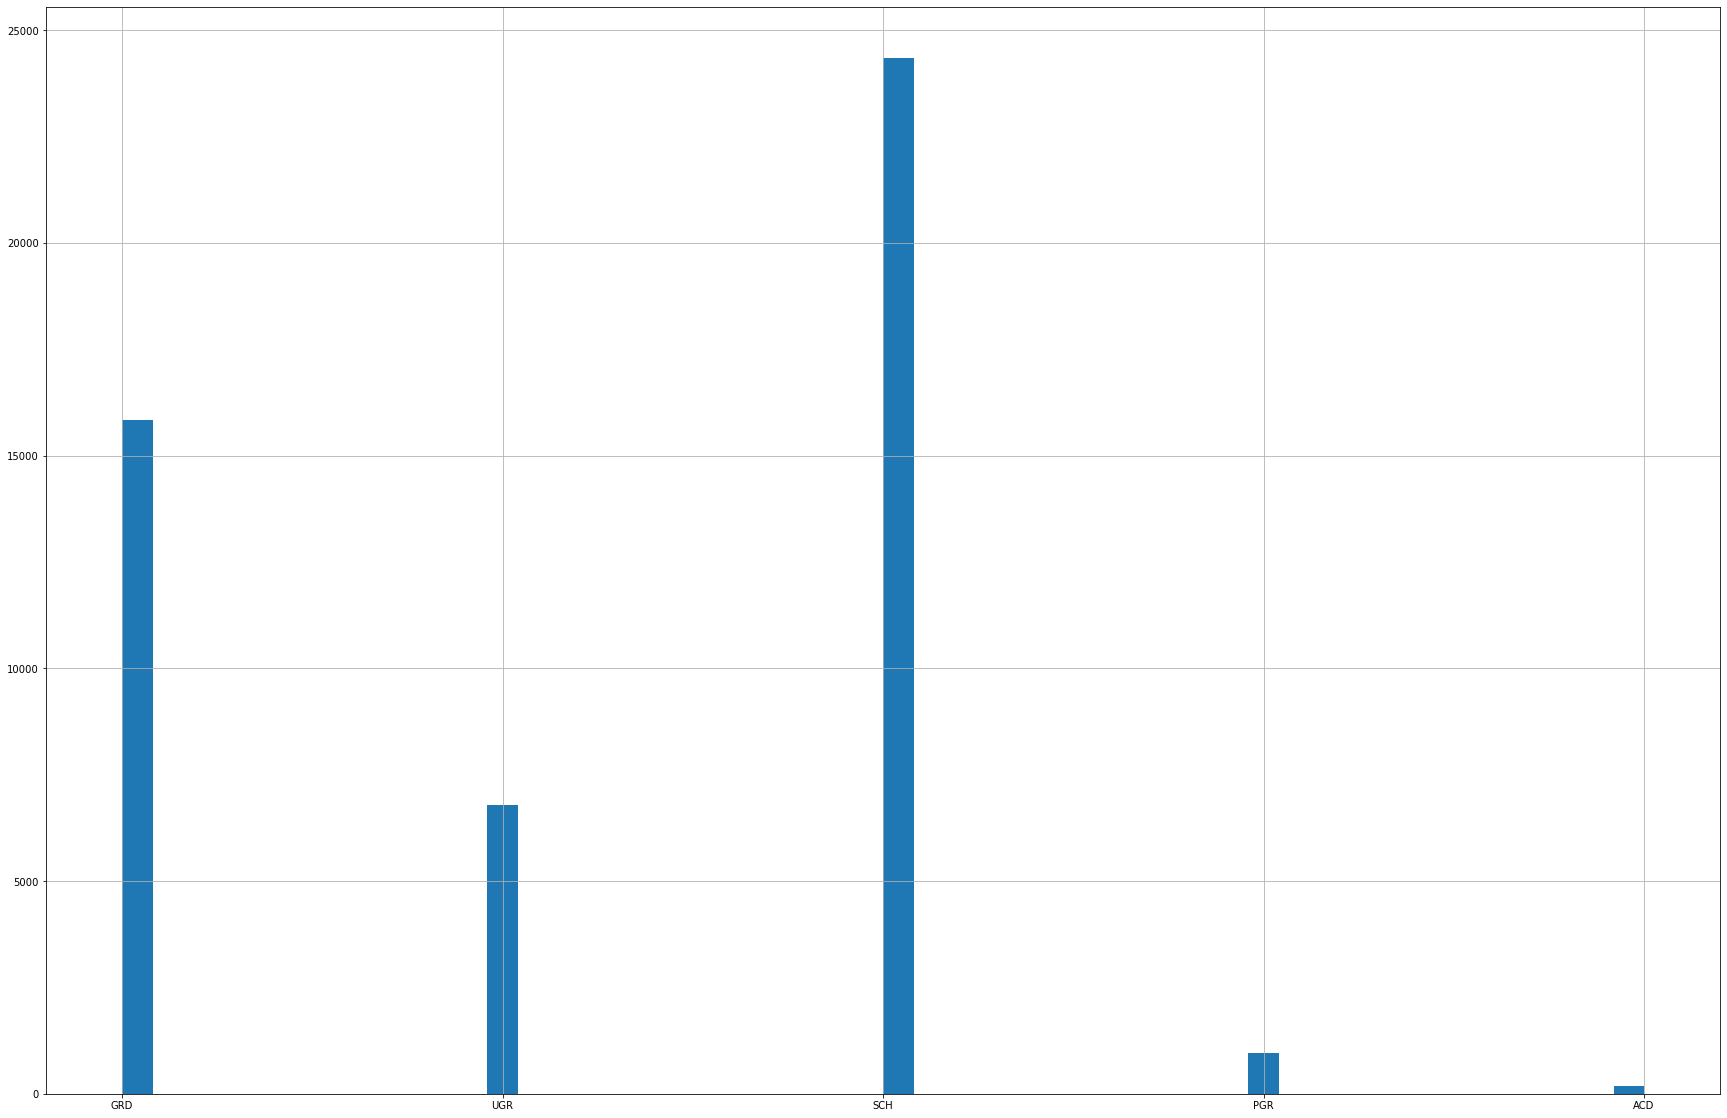

In [475]:
data['education'][data['sex'] == 'M'].hist(bins=50)

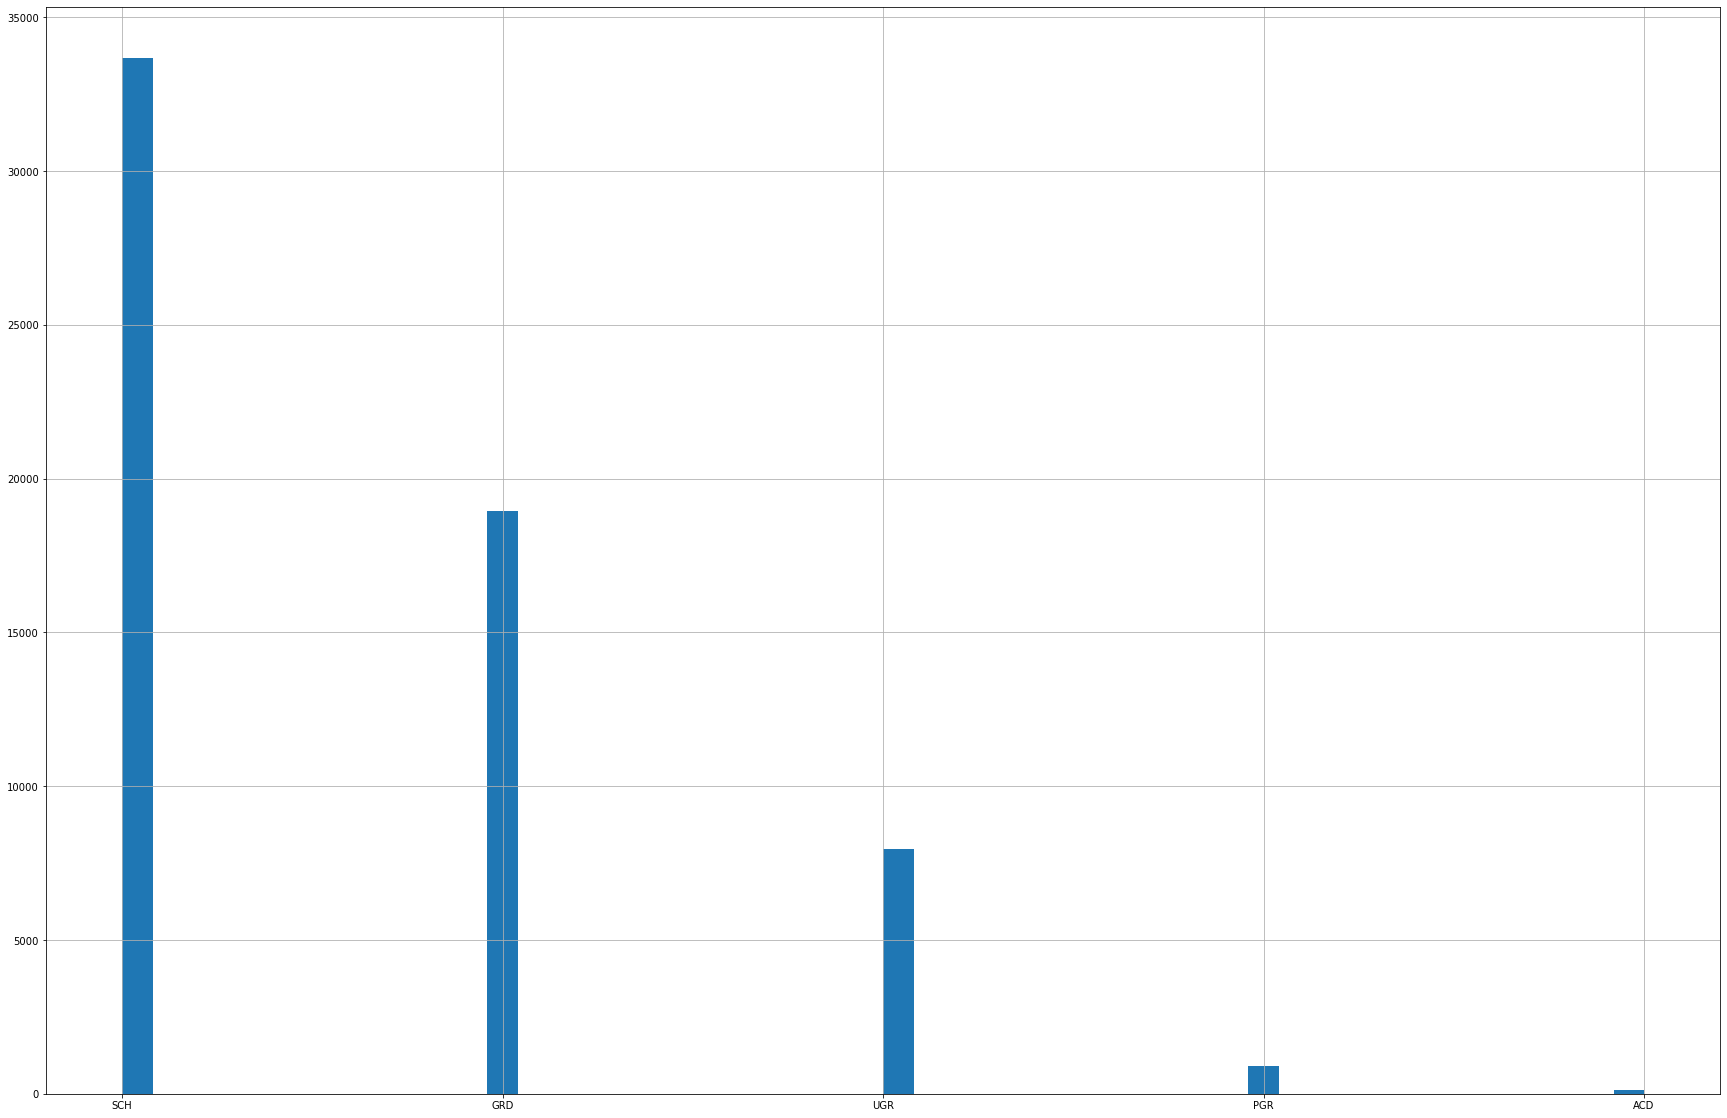

In [476]:
data['education'][data['sex'] == 'F'].hist(bins=50)

Здесь можно увидеть, что среди женщин больше клиентов со школьным образованием.  

Зависимость образования и дохода.

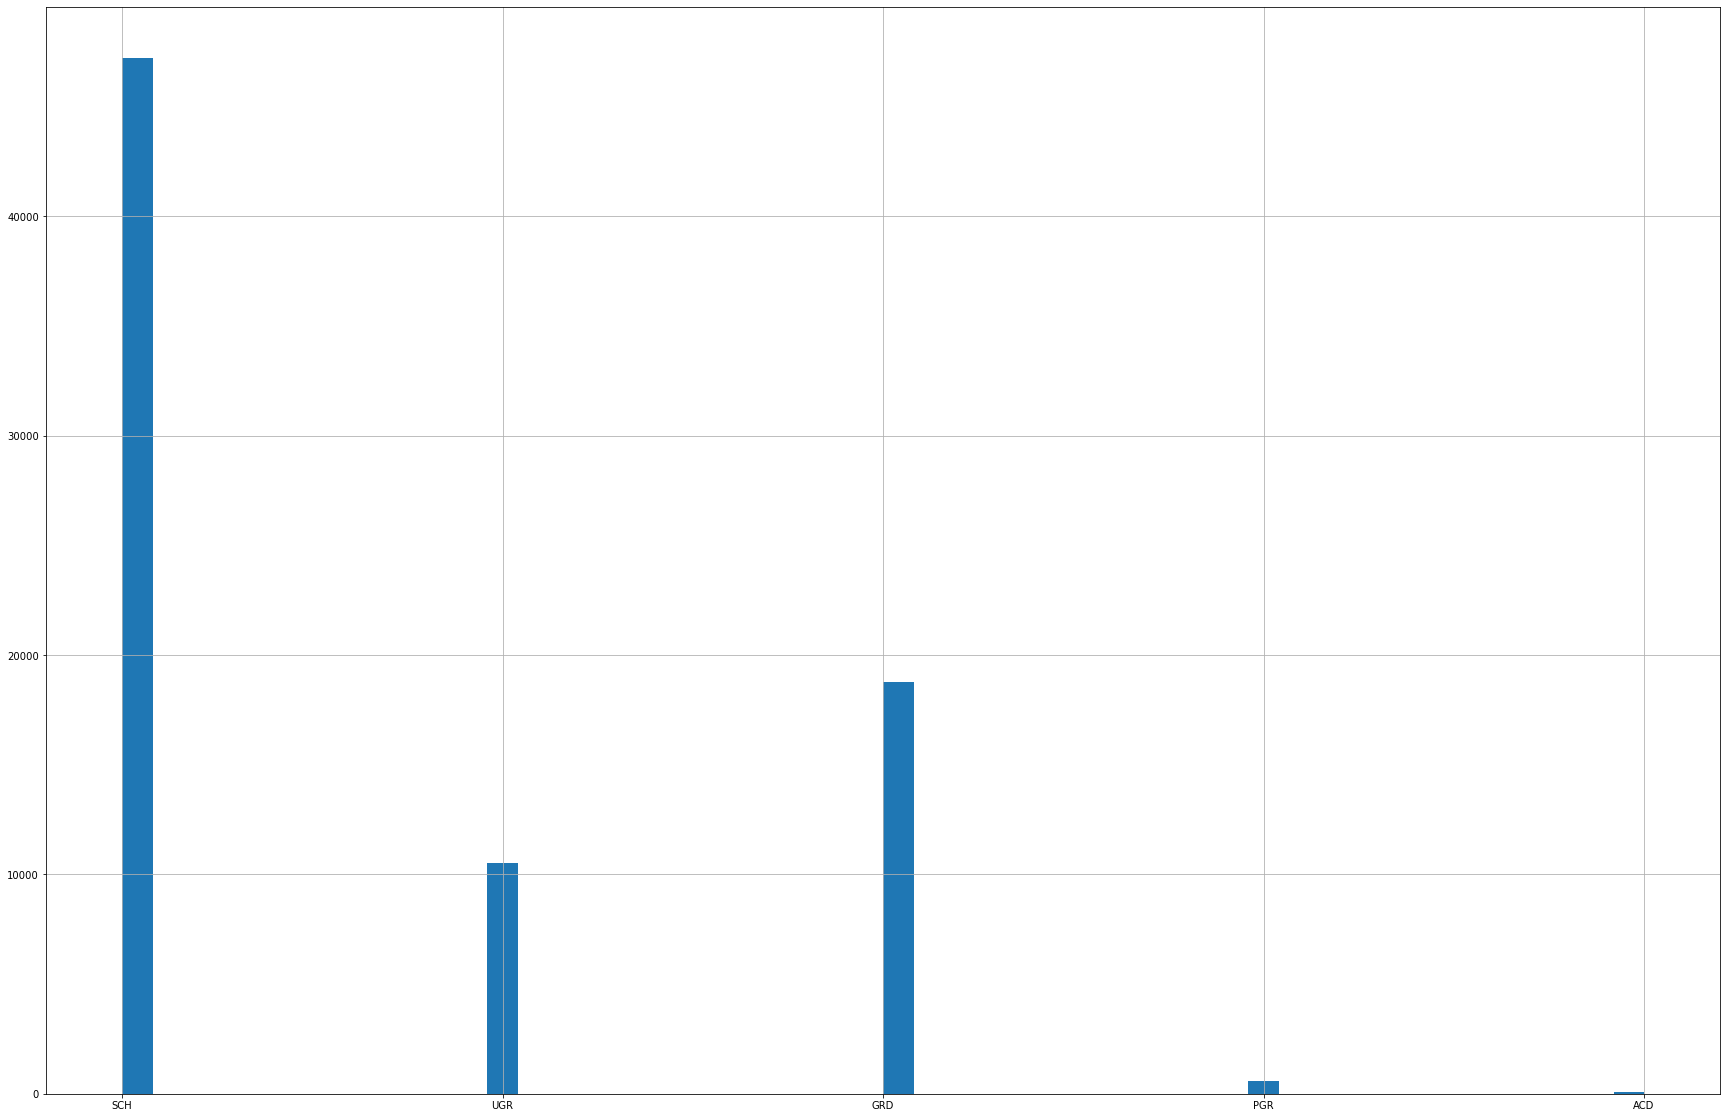

In [477]:
data['education'][data['income'] < data['income'].mean()].hist(bins=50)

Наибольшее количество клиентов с доходом меньше среднего имеют школьное образование.


Попробуем заполнить пропущенные значения с учетом полученных наблюдений.


In [478]:
# заполняем пропуски для клиентов женского пола с доходм меньше среднего значением SCH.
data['education'] = np.where((data['sex'] == 'F') & (data['income'] < data['income'].mean()) & (data['education'].isna()), 'SCH', data['education'])

In [479]:
# Проверим
data['education'].value_counts(dropna = False)

SCH    58195
GRD    34768
UGR    14748
PGR     1865
ACD      291
NaN      281
Name: education, dtype: int64

У нас осталось 281 пропущенное значение. Заполним их следующим по популярности значением.

In [480]:
data['education'] = data['education'].fillna('GRD')

In [481]:
# Проверим
data['education'].value_counts(dropna = False)

SCH    58195
GRD    35049
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

Пропущенных значений больше нет. 

#  2. region_rating

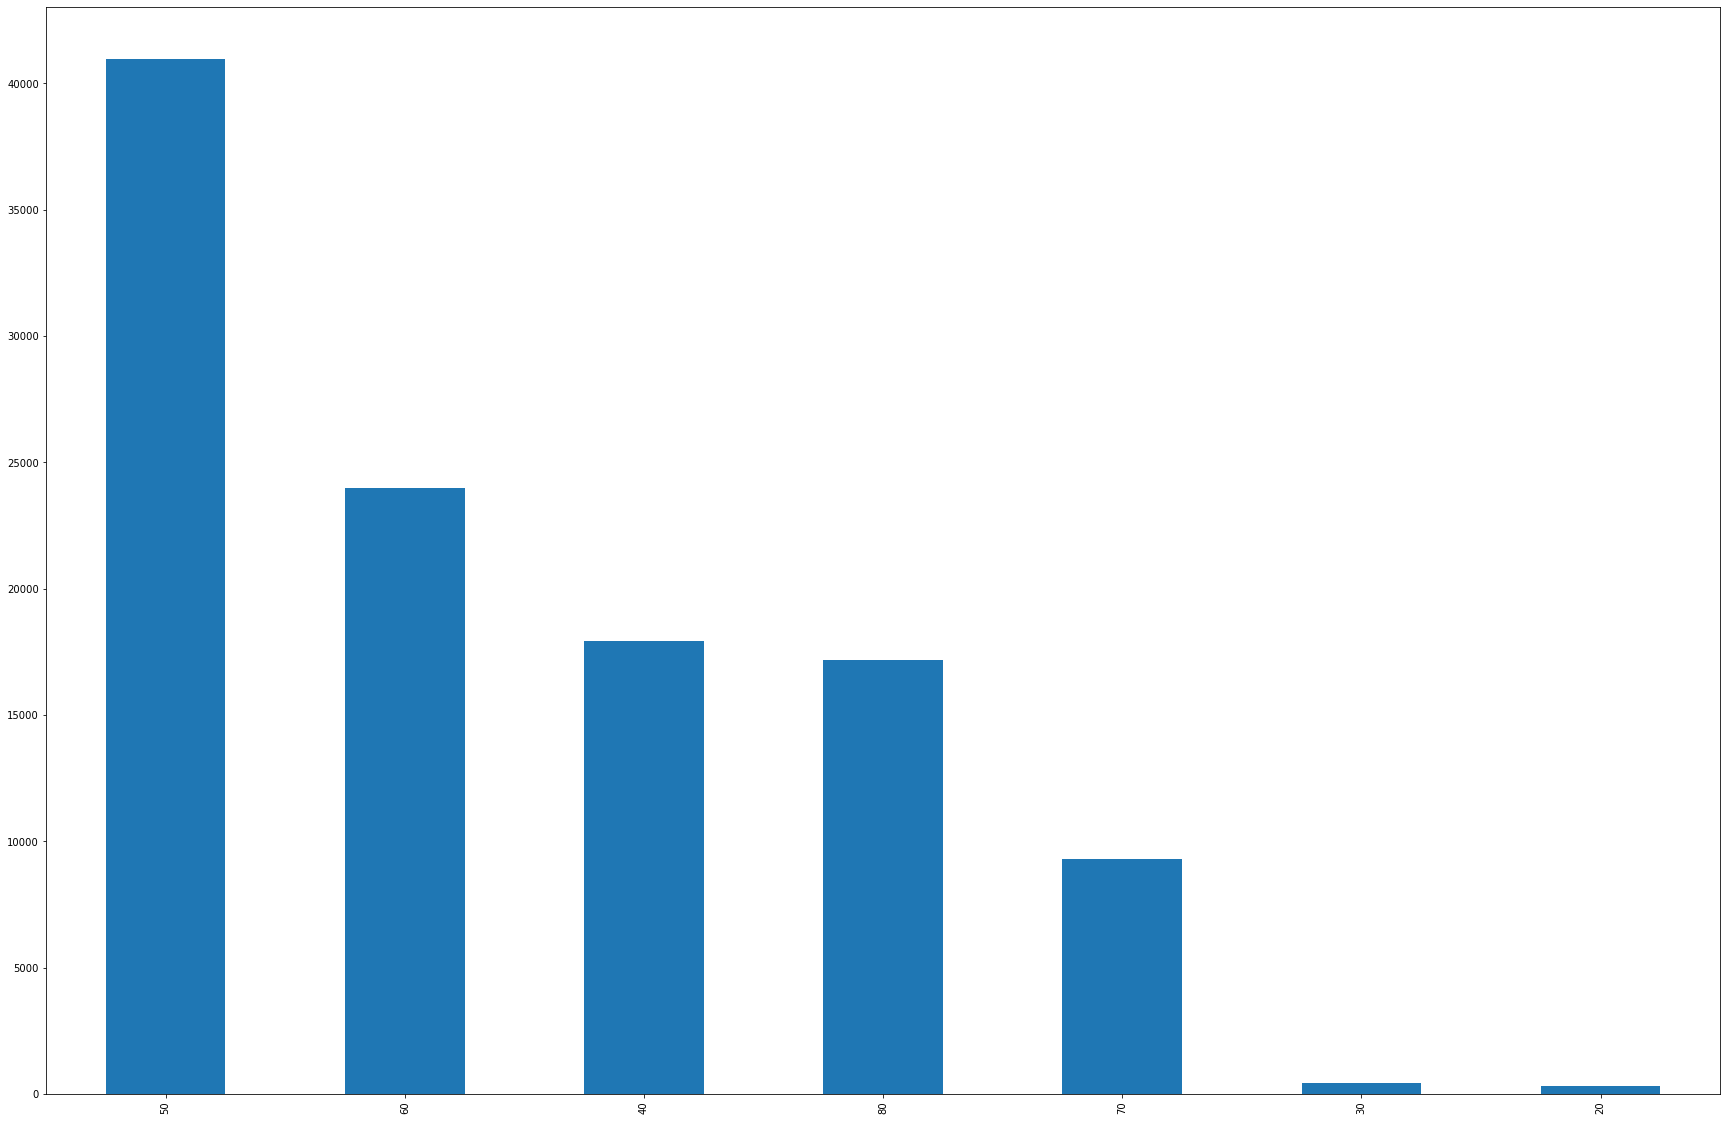

In [482]:
data['region_rating'].value_counts().plot.bar()

Не понятно, что скрывается за этими числами, но предположу, что чем меньше число тем выше рейтинг региона проживания клиента.

In [483]:
# создадим еще один столбец region_rating_freq - частота вхождения того или иного рейтинга в нашем дата-сете.
freq = data["region_rating"].value_counts(normalize = True)
data["region_rating_freq"] = data["region_rating"].map(freq)
data[["region_rating", "region_rating_freq"]].head(6)

,region_rating,region_rating_freq
0,50,0.372054
1,50,0.372054
2,50,0.372054
3,40,0.162935
4,80,0.155881
5,50,0.372054


# 3. app_date

In [484]:
# Преобразуем формат признака
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')

In [485]:
# вытащим из даты день недели
a = []
for i in data.app_date:
    a.append(i.weekday())

In [486]:
# создадим новый столбец
data['app_date_day'] = a
data['app_date_day']

0         5
1         4
2         6
3         0
4         1
         ..
110143    1
110144    0
110145    1
110146    5
110147    3
Name: app_date_day, Length: 110148, dtype: int64

In [487]:
# замена значений в столбце app_date на числа.
data.app_date = data.app_date.astype(int)

In [488]:
# проверим
data.app_date.value_counts()

1395100800000000000    1491
1395187200000000000    1363
1395014400000000000    1350
1396224000000000000    1317
1396828800000000000    1296
                       ... 
1397952000000000000     359
1389052800000000000     349
1388707200000000000     313
1388620800000000000     204
1388534400000000000      56
Name: app_date, Length: 120, dtype: int64

In [489]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   client_id           110148 non-null  int64  
 1   app_date            110148 non-null  int64  
 2   education           110148 non-null  object 
 3   sex                 110148 non-null  object 
 4   age                 110148 non-null  int64  
 5   car                 110148 non-null  object 
 6   car_type            110148 non-null  object 
 7   decline_app_cnt     110148 non-null  int64  
 8   good_work           110148 non-null  int64  
 9   score_bki           110148 non-null  float64
 10  bki_request_cnt     110148 non-null  int64  
 11  region_rating       110148 non-null  int64  
 12  home_address        110148 non-null  int64  
 13  work_address        110148 non-null  int64  
 14  income              110148 non-null  int64  
 15  sna                 110148 non-nul

# 3. sex 

Общеизвестный факт - женщины более аккуратны при пользовании кредитными продуктами. Попробуем это использовать.

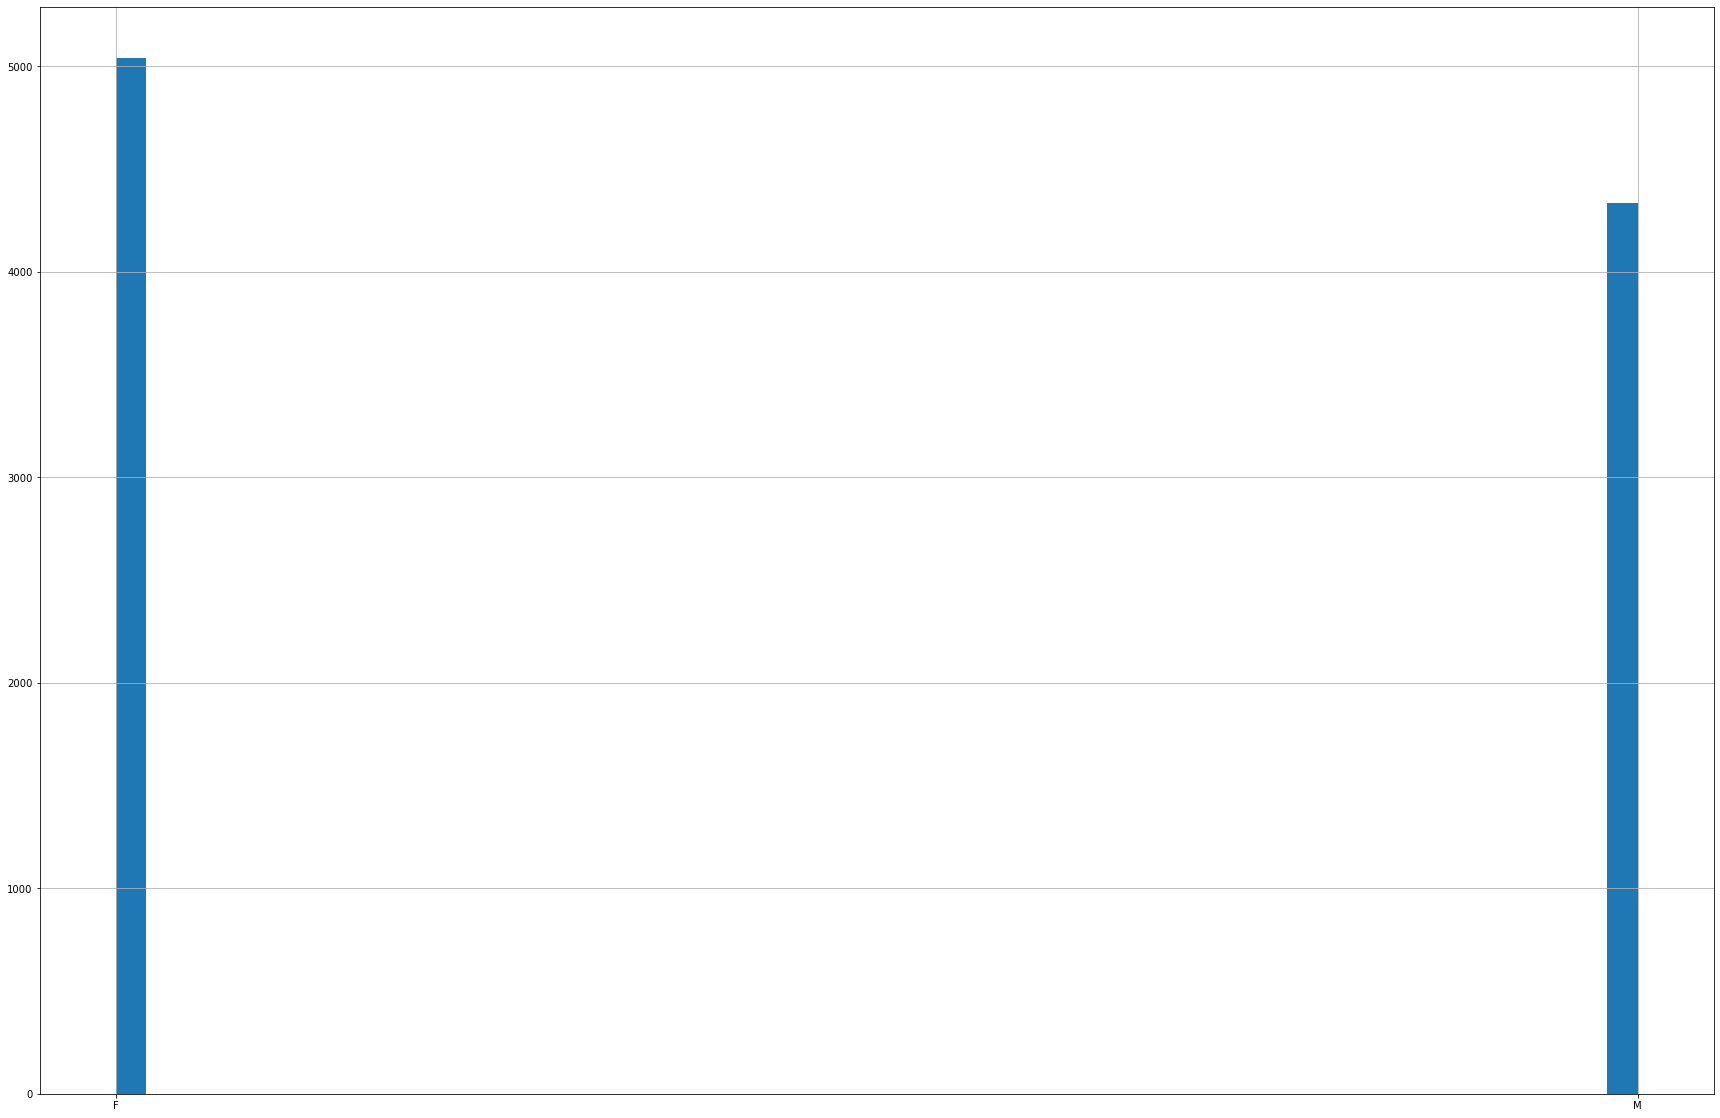

In [490]:
data['sex'][data['default'] == 1].hist(bins=50)

Gолучилось наоборот... потому, что количество клиентов женского пола болше чем мужского.

In [491]:
data['sex'].value_counts()

F    61836
M    48312
Name: sex, dtype: int64

In [492]:
# оздадим новые признаки - предположим, что клиент женского пола, с доходом ниже среднего, с оценкой БКИ ниже среднего будет дефолтным.
data['female_default'] = 0
data['female_default'] = np.where((data['sex'] == 'F') & (data['income'] < data['income'].mean()) & (data['score_bki'] < data['score_bki'].mean()), '1', data['female_default'] )
data['female_default'] = data['female_default'].astype(int)

In [493]:
# проверка
data.female_default.value_counts()

0    85356
1    24792
Name: female_default, dtype: int64

In [494]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   client_id           110148 non-null  int64  
 1   app_date            110148 non-null  int64  
 2   education           110148 non-null  object 
 3   sex                 110148 non-null  object 
 4   age                 110148 non-null  int64  
 5   car                 110148 non-null  object 
 6   car_type            110148 non-null  object 
 7   decline_app_cnt     110148 non-null  int64  
 8   good_work           110148 non-null  int64  
 9   score_bki           110148 non-null  float64
 10  bki_request_cnt     110148 non-null  int64  
 11  region_rating       110148 non-null  int64  
 12  home_address        110148 non-null  int64  
 13  work_address        110148 non-null  int64  
 14  income              110148 non-null  int64  
 15  sna                 110148 non-nul

In [495]:
# для клиентов мужского пола возьмем другие взаимосвязи - возраст меньше среднего, без хорошей работы.
data['male_default'] = 0
data['male_default'] = np.where((data['sex'] == 'M') & (data['age'] < data['age'].mean()) & (data['good_work'] == 0), '1', data['male_default'] )
data['male_default'] = data['male_default'].astype(int)

# 4. income

In [496]:
data.income.value_counts()

30000     10437
25000      9090
20000      8174
40000      7383
50000      6742
          ...  
27478         1
27350         1
20412         1
23120         1
426000        1
Name: income, Length: 1207, dtype: int64

In [497]:
print(data.income.min())
print(data.income.max())

1000
1000000


In [498]:
# определение границ выбросов
median = data.income.median()
IQR = data.income.quantile(0.75) - data.income.quantile(0.25)
perc25 = data.income.quantile(0.25)
perc75 = data.income.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].


Логика подсказывает, что не стоит заменять данные с учетом предполагаемых выбросов. Столбец доходы может иметь совершенно разные значения.

In [499]:
# Хотя я попробовал и так и так)
# data['income'] = np.where(data['income']<-22000.0,data['income'].median(), data['income'])

Создадим еще признаков из различных взаимосвязей

In [500]:
# клиент с хорошей работой, с хорошей машиной предположительно платежеспособен
data['whithout_default'] = 0
data['whithout_default'] = np.where((data['good_work'] == 1) & (data['car_type'] =='Y') , '1', data['whithout_default'] )
data['whithout_default'] = data['whithout_default'].astype(int)

In [501]:
# клиент с заграничным паспортом, с хорошей машиной также будет платежеспособен
data['whithout_default2'] = 0
data['whithout_default2'] = np.where((data['foreign_passport'] == 'Y') & (data['car_type'] =='Y') , '1', data['whithout_default2'] )
data['whithout_default2'] = data['whithout_default2'].astype(int)

In [502]:
# клиент с отсутвием запросов в БКИ и отсутствием отказов, да и еще с хорошей работой платежеспособен
data['whithout_default3'] = 0
data['whithout_default3'] = np.where((data['decline_app_cnt'] == 0) & (data['bki_request_cnt'] == 0)& (data['income'] > data['income'].mean()) , '1', data['whithout_default3'] )
data['whithout_default3'] = data['whithout_default3'].astype(int)

# Подготовка данных для обучения.

In [503]:
# Из курса известно что необходимо прологорифмировать значения отдельных признаков:

data['age'] = np.log(data['age'] + 1)
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
data['bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)
data['income'] = np.log(data['income'] + 1)

Для бинарных переменных используем LabelEncoder. # bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [504]:
label_encoder = LabelEncoder()

In [505]:
data['sex'] = pd.Series(label_encoder.fit_transform(data['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [506]:
data['car'] = pd.Series(label_encoder.fit_transform(data['car']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'N', 1: 'Y'}


In [507]:
data['car_type'] = pd.Series(label_encoder.fit_transform(data['car_type']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'N', 1: 'Y'}


In [508]:
data['foreign_passport'] = pd.Series(label_encoder.fit_transform(data['foreign_passport']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'N', 1: 'Y'}


Значений типа object в нашем датасете больше нет (кроме app_date).

Проверим на сколько изменится score.

score 0.72755

In [509]:
# реализуем метод OneHotLabels через get_dummies для категориальных признаков
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'app_date_day']

data=pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

In [510]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 53 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   client_id           110148 non-null  int64  
 1   app_date            110148 non-null  int64  
 2   sex                 110148 non-null  int64  
 3   age                 110148 non-null  float64
 4   car                 110148 non-null  int64  
 5   car_type            110148 non-null  int64  
 6   decline_app_cnt     110148 non-null  float64
 7   good_work           110148 non-null  int64  
 8   score_bki           110148 non-null  float64
 9   bki_request_cnt     110148 non-null  float64
 10  income              110148 non-null  float64
 11  foreign_passport    110148 non-null  int64  
 12  sample              110148 non-null  int64  
 13  default             110148 non-null  int64  
 14  region_rating_freq  110148 non-null  float64
 15  female_default      110148 non-nul

In [511]:
# для того чтобы выбрать значимые признаки воспользуемся следуещей функцией:
def get_stat_dif(column):
    cols = data.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'default'], data.loc[data.loc[:, column] == comb[1], 'default']).pvalue <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [512]:
list(data.columns.values)

['client_id',
 'app_date',
 'sex',
 'age',
 'car',
 'car_type',
 'decline_app_cnt',
 'good_work',
 'score_bki',
 'bki_request_cnt',
 'income',
 'foreign_passport',
 'sample',
 'default',
 'region_rating_freq',
 'female_default',
 'male_default',
 'whithout_default',
 'whithout_default2',
 'whithout_default3',
 'education_ACD',
 'education_GRD',
 'education_PGR',
 'education_SCH',
 'education_UGR',
 'region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80',
 'home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'work_address_3',
 'sna_1',
 'sna_2',
 'sna_3',
 'sna_4',
 'first_time_1',
 'first_time_2',
 'first_time_3',
 'first_time_4',
 'app_date_day_0',
 'app_date_day_1',
 'app_date_day_2',
 'app_date_day_3',
 'app_date_day_4',
 'app_date_day_5',
 'app_date_day_6']

In [513]:
cat_cols

['education',
 'region_rating',
 'home_address',
 'work_address',
 'sna',
 'first_time',
 'app_date_day']

In [514]:
bin_cols

['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [515]:
for cols in ['education_ACD',
 'education_GRD',
 'education_PGR',
 'education_SCH',
 'education_UGR','region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80','home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'work_address_3', 'sna_1',
 'sna_2',
 'sna_3',
 'sna_4',
 'first_time_1',
 'first_time_2',
 'first_time_3',
 'first_time_4', 'female_default', 'whithout_default', 'whithout_default2', 'male_default', 'whithout_default3', 'app_date_day_0','app_date_day_1','app_date_day_2','app_date_day_3','app_date_day_4','app_date_day_5','app_date_day_6' ]:
    get_stat_dif(cols)
 

Найдены статистически значимые различия для колонки education_ACD
Найдены статистически значимые различия для колонки education_GRD
Найдены статистически значимые различия для колонки education_PGR
Найдены статистически значимые различия для колонки education_SCH
Найдены статистически значимые различия для колонки region_rating_20
Найдены статистически значимые различия для колонки region_rating_30
Найдены статистически значимые различия для колонки region_rating_40
Найдены статистически значимые различия для колонки region_rating_50
Найдены статистически значимые различия для колонки region_rating_70
Найдены статистически значимые различия для колонки region_rating_80
Найдены статистически значимые различия для колонки home_address_1
Найдены статистически значимые различия для колонки home_address_2
Найдены статистически значимые различия для колонки work_address_1
Найдены статистически значимые различия для колонки work_address_2
Найдены статистически значимые различия для колонки wo

Удаление столбцов не влияющих на нашу целевую переменную в конце подготовки данных

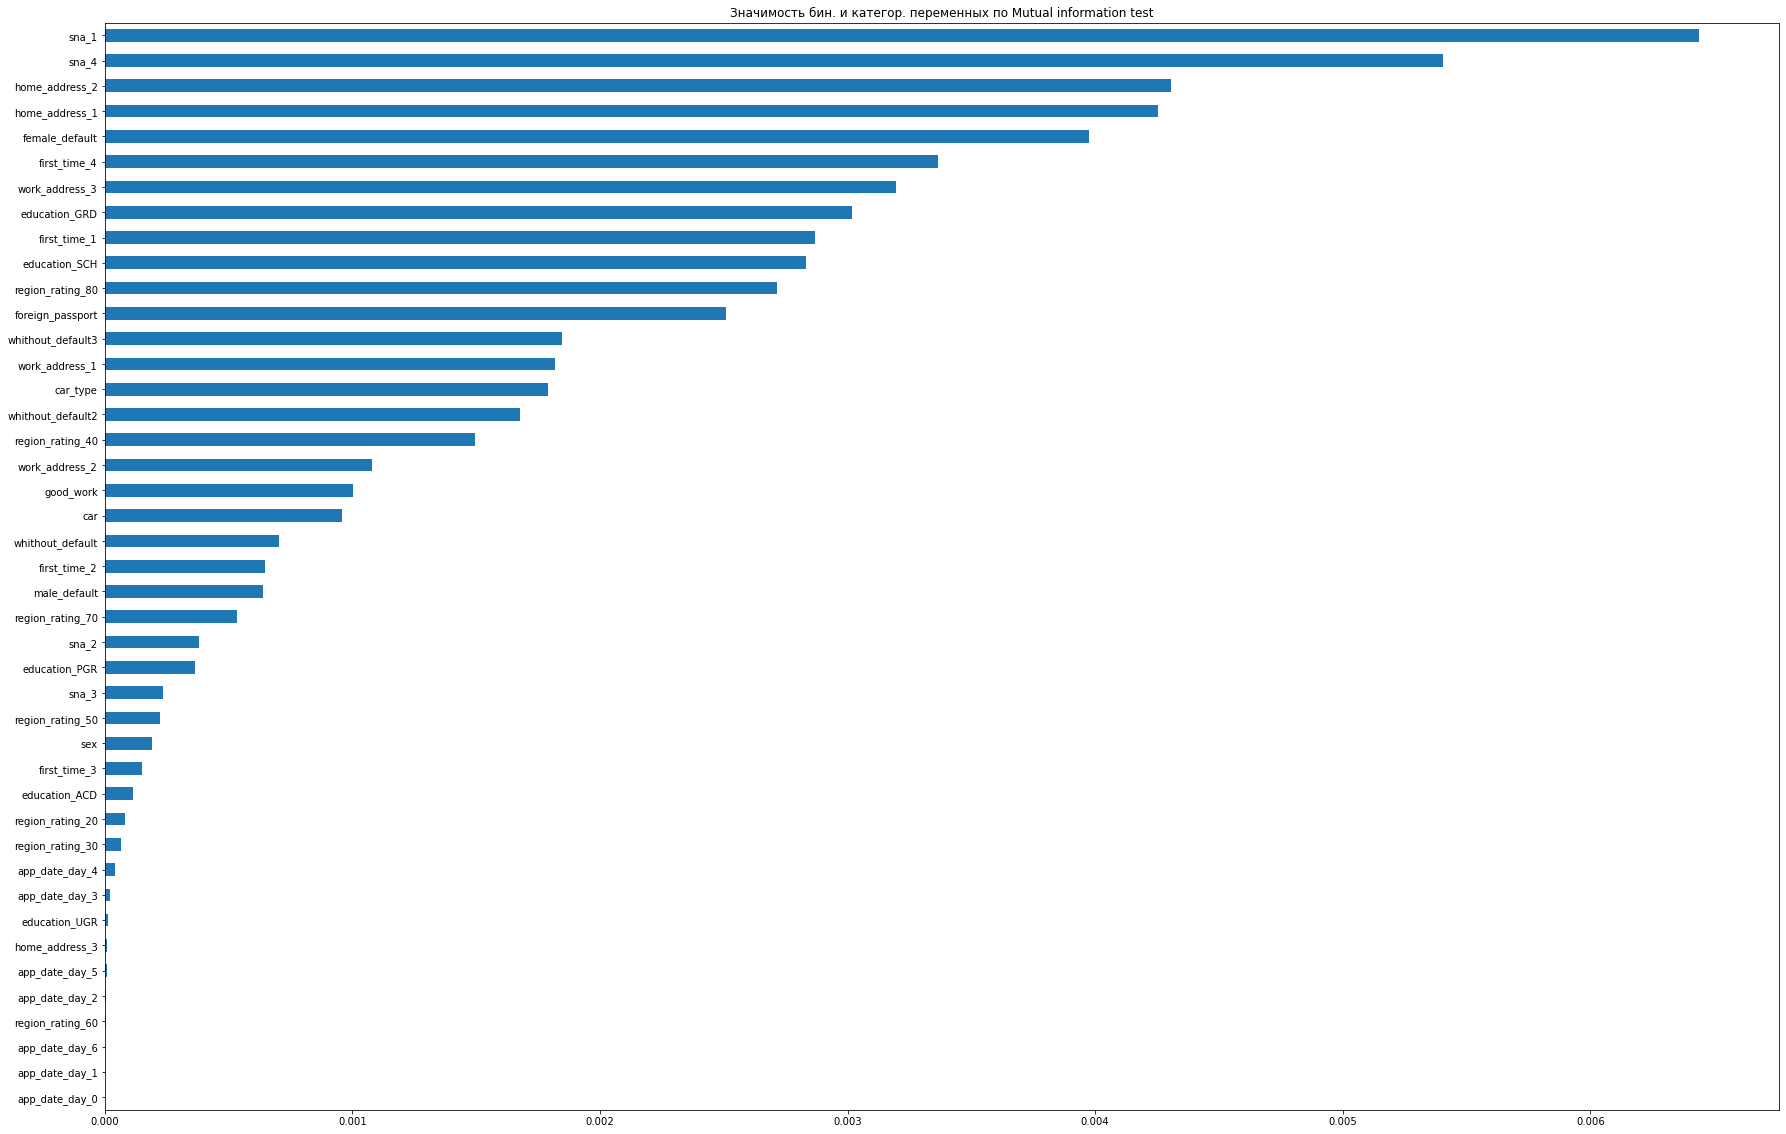

In [516]:
# Анализ уровня значимости категориальных и бинарных признаков
all_cat_and_bin_cols = ['education_ACD',
 'education_GRD',
 'education_PGR',
 'education_SCH',
 'education_UGR','region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80','home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'work_address_3', 'sna_1',
 'sna_2',
 'sna_3',
 'sna_4',
 'first_time_1',
 'first_time_2',
 'first_time_3',
 'first_time_4', 'sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'female_default','male_default', 'whithout_default', 'whithout_default2', 'whithout_default3', 'app_date_day_0','app_date_day_1','app_date_day_2','app_date_day_3','app_date_day_4','app_date_day_5','app_date_day_6']
temp_df = data[data['sample']==1]
imp_cat = pd.Series(mutual_info_classif(temp_df[all_cat_and_bin_cols], temp_df['default'], discrete_features =True), index = all_cat_and_bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title = 'Значимость бин. и категор. переменных по Mutual information test')

Наиболее значимым признаком среди категориальных и бинарных является sna - связь заемщика с клиентами банка.

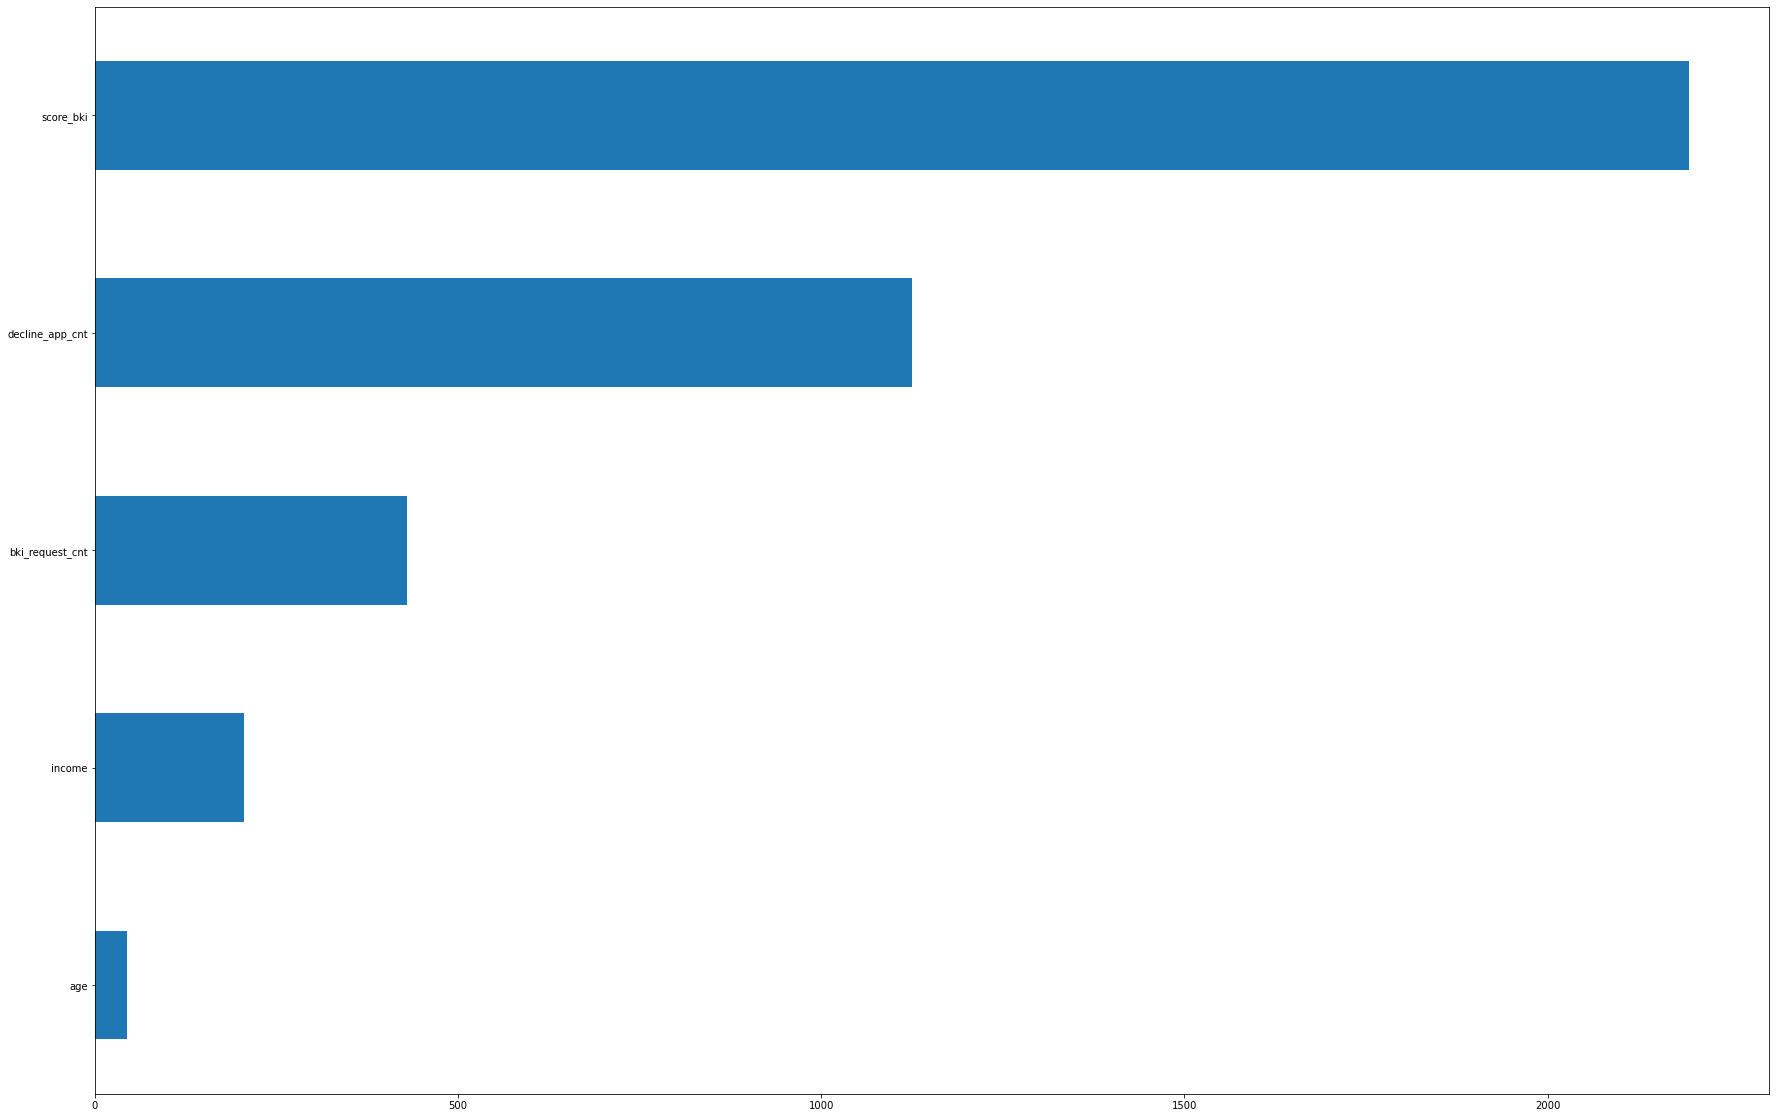

In [517]:
# Анализ уровня значимости для числовых признаков
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [518]:
list(data.columns.values)

['client_id',
 'app_date',
 'sex',
 'age',
 'car',
 'car_type',
 'decline_app_cnt',
 'good_work',
 'score_bki',
 'bki_request_cnt',
 'income',
 'foreign_passport',
 'sample',
 'default',
 'region_rating_freq',
 'female_default',
 'male_default',
 'whithout_default',
 'whithout_default2',
 'whithout_default3',
 'education_ACD',
 'education_GRD',
 'education_PGR',
 'education_SCH',
 'education_UGR',
 'region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80',
 'home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'work_address_3',
 'sna_1',
 'sna_2',
 'sna_3',
 'sna_4',
 'first_time_1',
 'first_time_2',
 'first_time_3',
 'first_time_4',
 'app_date_day_0',
 'app_date_day_1',
 'app_date_day_2',
 'app_date_day_3',
 'app_date_day_4',
 'app_date_day_5',
 'app_date_day_6']

In [519]:
data.drop(['app_date_day_0','app_date_day_1','app_date_day_2','app_date_day_3','app_date_day_5','app_date_day_6','education_UGR', 'first_time_3', 'car','sna_3','sna_2', 'education_SCH','education_GRD', 'region_rating_60','region_rating_50', 'home_address_1', 'work_address_3','work_address_1', 'work_address_2'], axis='columns', inplace=True)

In [520]:
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income', 'region_rating_freq']


In [521]:
#Стандартизация числовых переменных
data[all_time_and_num_cols] = StandardScaler().fit_transform(data[all_time_and_num_cols].values)

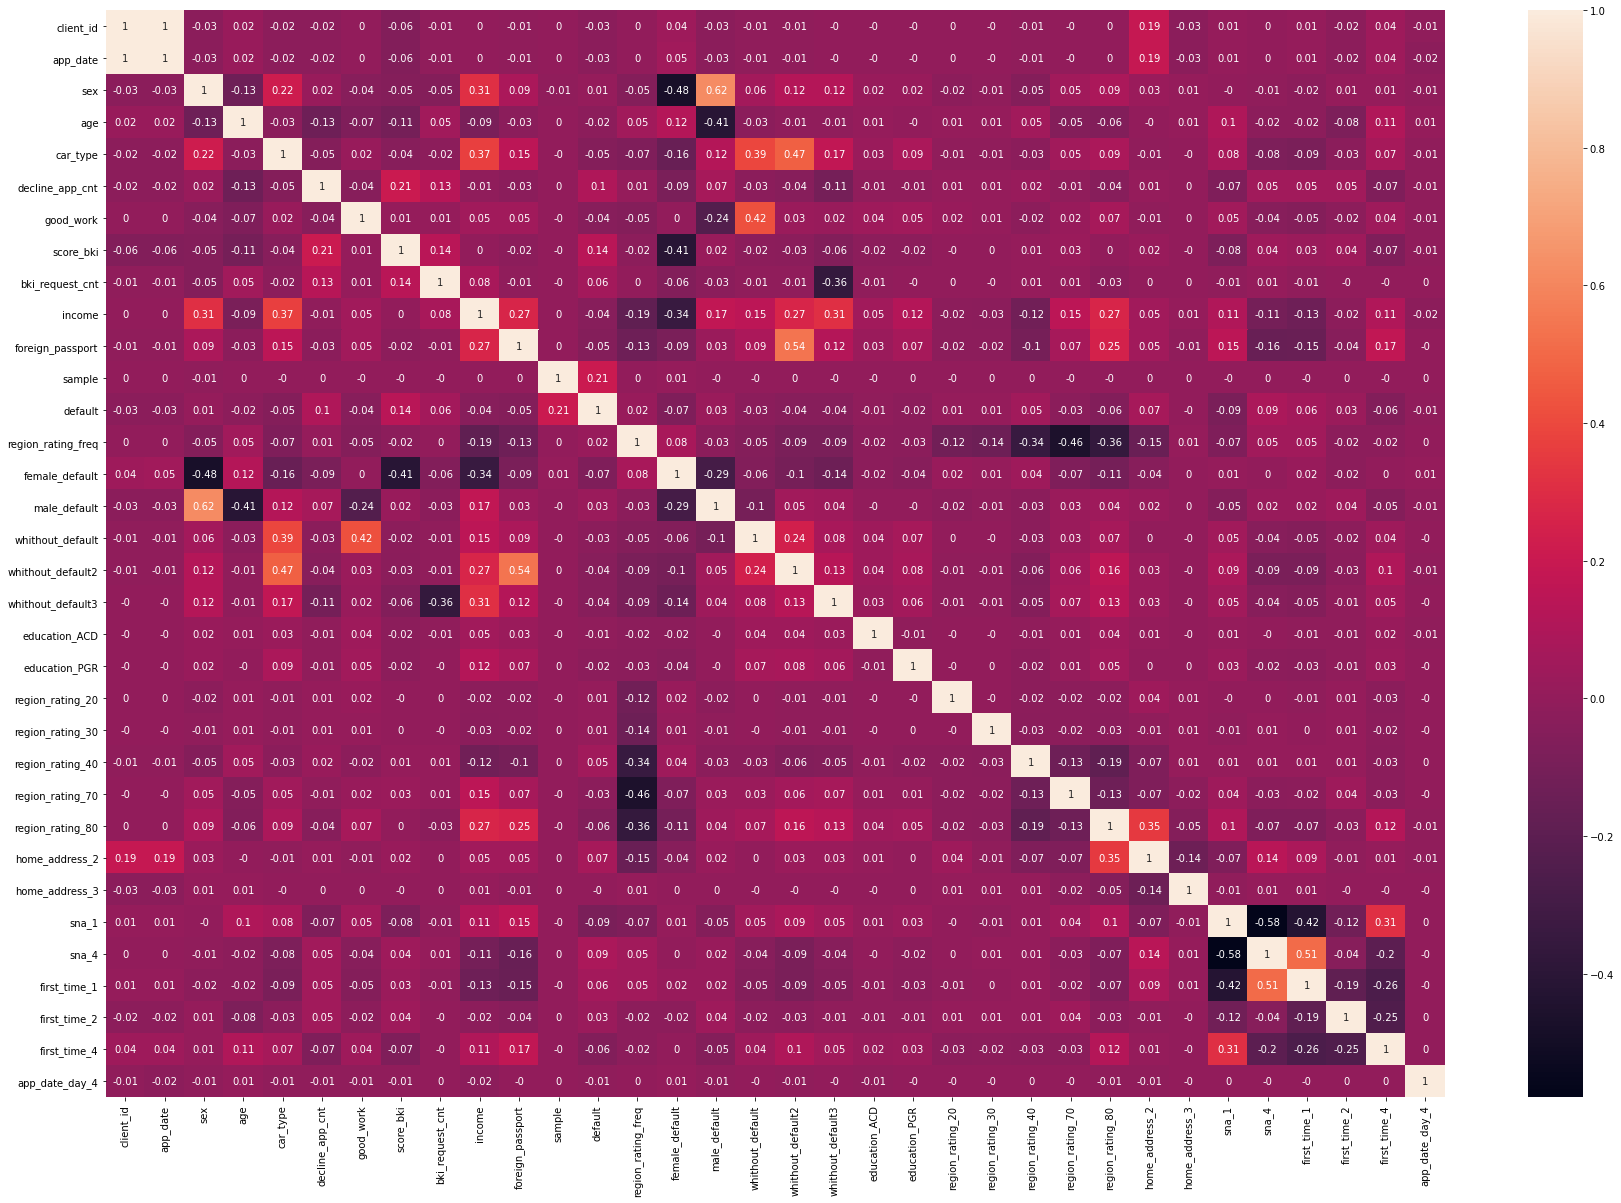

In [522]:
plt.rcParams['figure.figsize'] = (30,20)
sns.heatmap(data.corr().round(2), annot = True) 

Учитывая что наша выборка является несбалансированной представляется целесообразным уменьшить количество объектов превалирующих классов (undersampling)

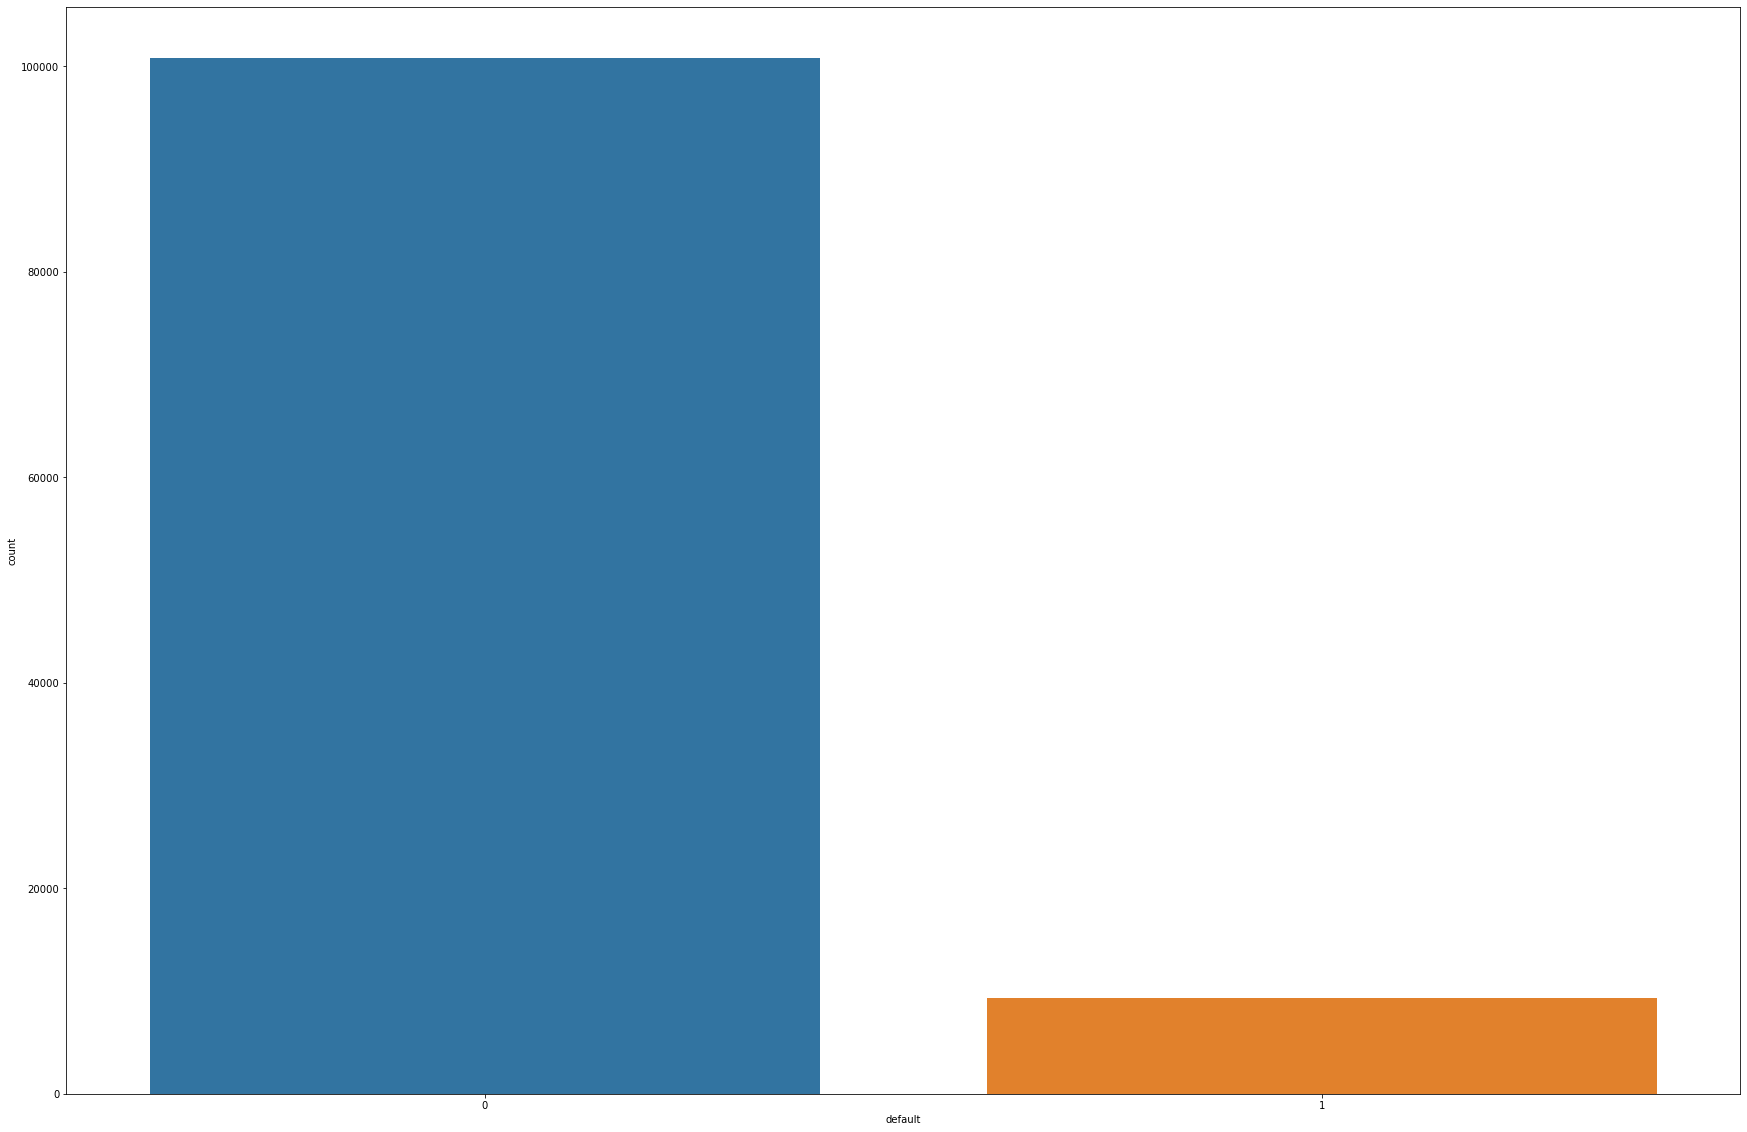

In [523]:
sns.countplot(x='default', data=data)

In [524]:
# Найдем количество клиентов, которые являются превалирующим классом
frauds = len(data[data['default'] == 1])

In [525]:
# возьмем индексы клиентов - не превалирующего класса
non_fraud_indices = data[data.default == 0].index


In [526]:
# Индексы случайной выборки не связанные с превалирующим классом
random_indices = np.random.choice(non_fraud_indices,frauds, replace=False)

In [527]:
# найдем индексы превалирующего класса
fraud_indices = data[data.default == 1].index

In [528]:
# Объединим
under_sample_indices = np.concatenate([fraud_indices,random_indices])

In [529]:
under_sample = data.loc[under_sample_indices]

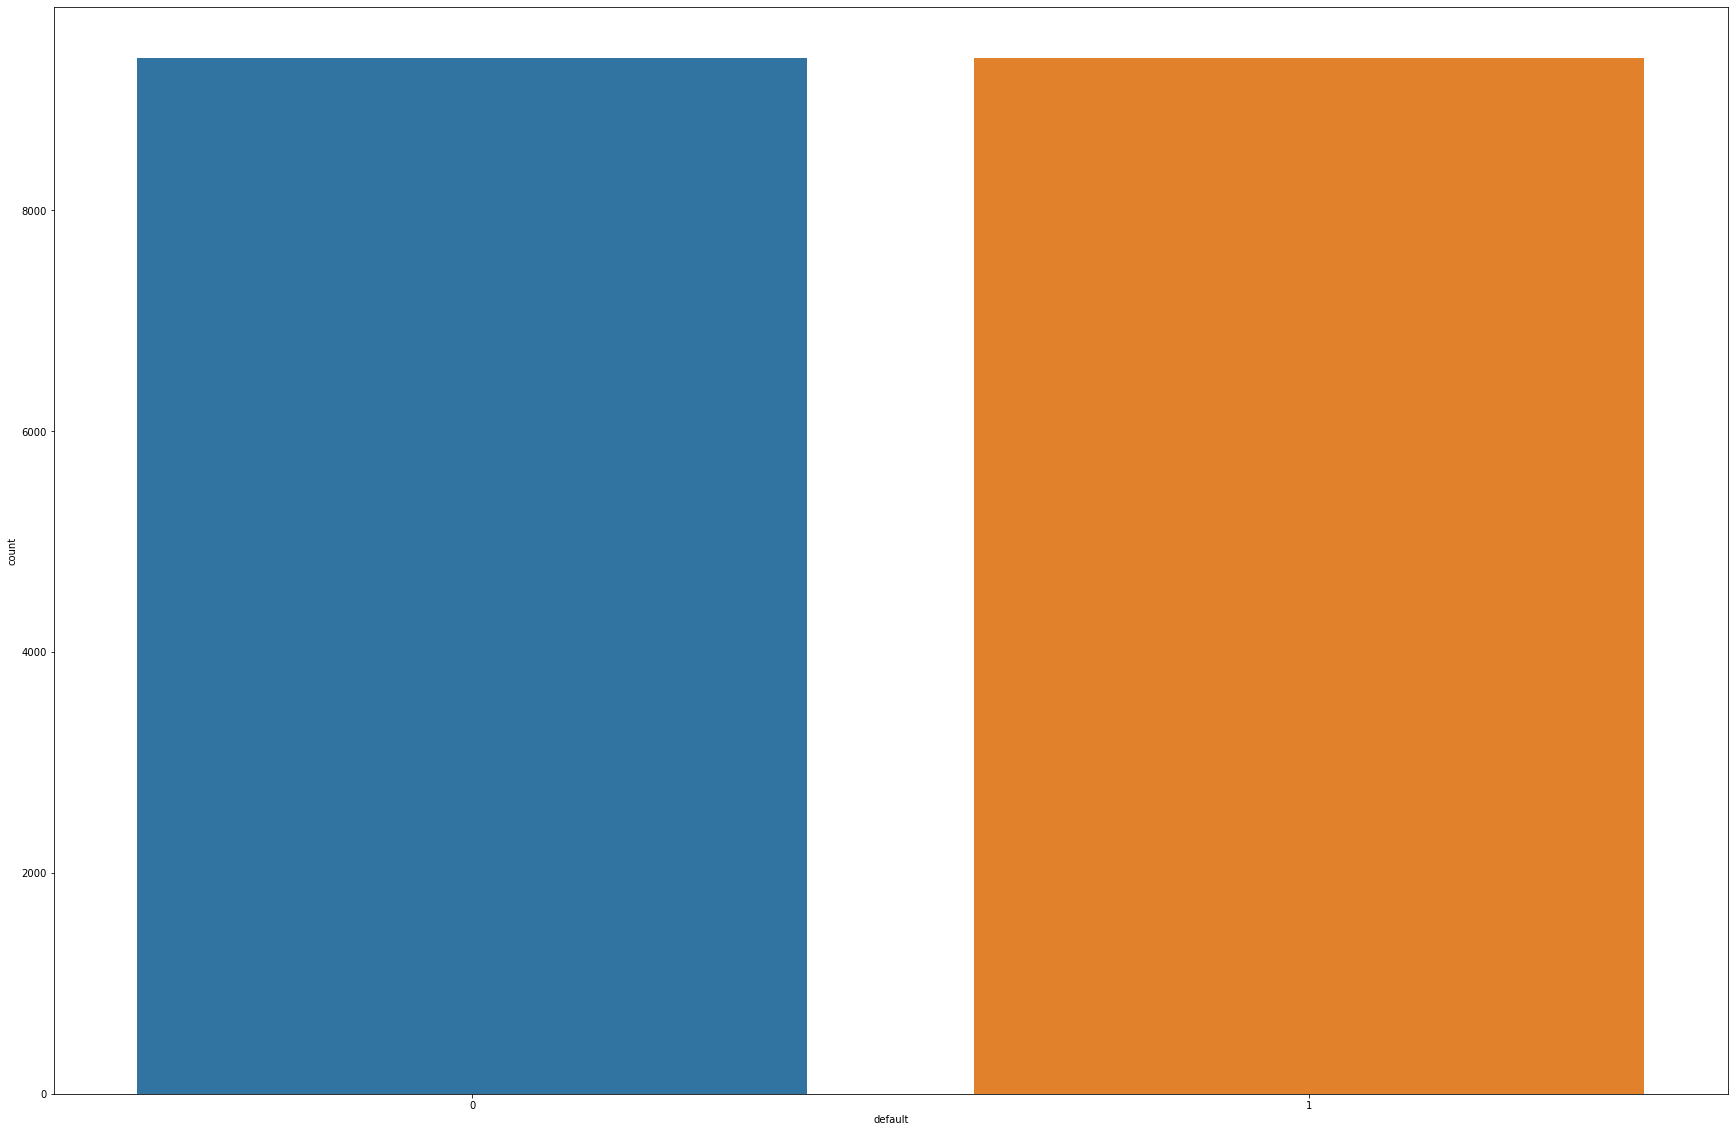

In [530]:
sns.countplot(x='default', data=under_sample)

После применения undersampling score  составил 0.73084

In [531]:
# Разделение данных на train an test. 
# разделение и дальнейшее обучение на сбалансированной выборке показало не самый лучший результат с учетом 
# выбранной метрики. Так самое лучшее, что удалось добиться это 49 место на Kaggle.

#train_data = under_sample.query('sample == 1').drop(['sample', 'client_id'], axis=1)

train_data = data.query('sample == 1').drop(['sample', 'client_id'], axis=1)

test_data = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

In [532]:
# Действие относится к первым 3 попыткам.
#train_data = data.query('sample == 1').drop(['sample', 'client_id'], axis=1)
#test_data = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

In [533]:
X_train=train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)
y_test = test_data.default.values

In [534]:
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((36349, 32), (73799, 32), (73799, 31), (73799,), (36349, 31), (36349,))

In [535]:
# Здесь были опробованы различные модели RandomForestClassifier, GradientBoostingClassifier, KNeighborsClassifier,
# GaussianNB, LogisticRegression. Но наилучший результат Score = 0.73621 получился с GradientBoostingClassifier.
model = GradientBoostingClassifier(learning_rate=0.2, min_samples_leaf = 4, max_features=0.4)

In [536]:
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [537]:
preds = model.predict(X_train)

In [538]:
# confusion_matrix
conf_mat = metrics.confusion_matrix(y_train, preds)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

,0,1
0,64243,184
1,9127,245


Судя по данным confusion_matrix при применении несбалансированной выборки у нас 9 тысяч ложно отрицательных значения. (дефолт классифицирован как не-дефолт). Что критично для бизнеса, ввиду значительных возможных финансовых потерь.



После обучения модели на сбалансированной выборке количество ложно отрицательных значений снизилось до 1тыс., зато увеличилось количество лолжно положительных значений
(не-дефолт классифицирован как дефолт). Данная ситуация является более предпочтительной ввиду того, что в ситуации когда кредит не выдан клиенту который бы вернул деньги банк теряет прибыл в видете процента по кредиту. В ситуации же когда кредит выдается дефолтному клиенту банк теряет 100% выданного кредита.

In [539]:
pred_prob = model.predict_proba(X_train)

In [540]:
preds = pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)


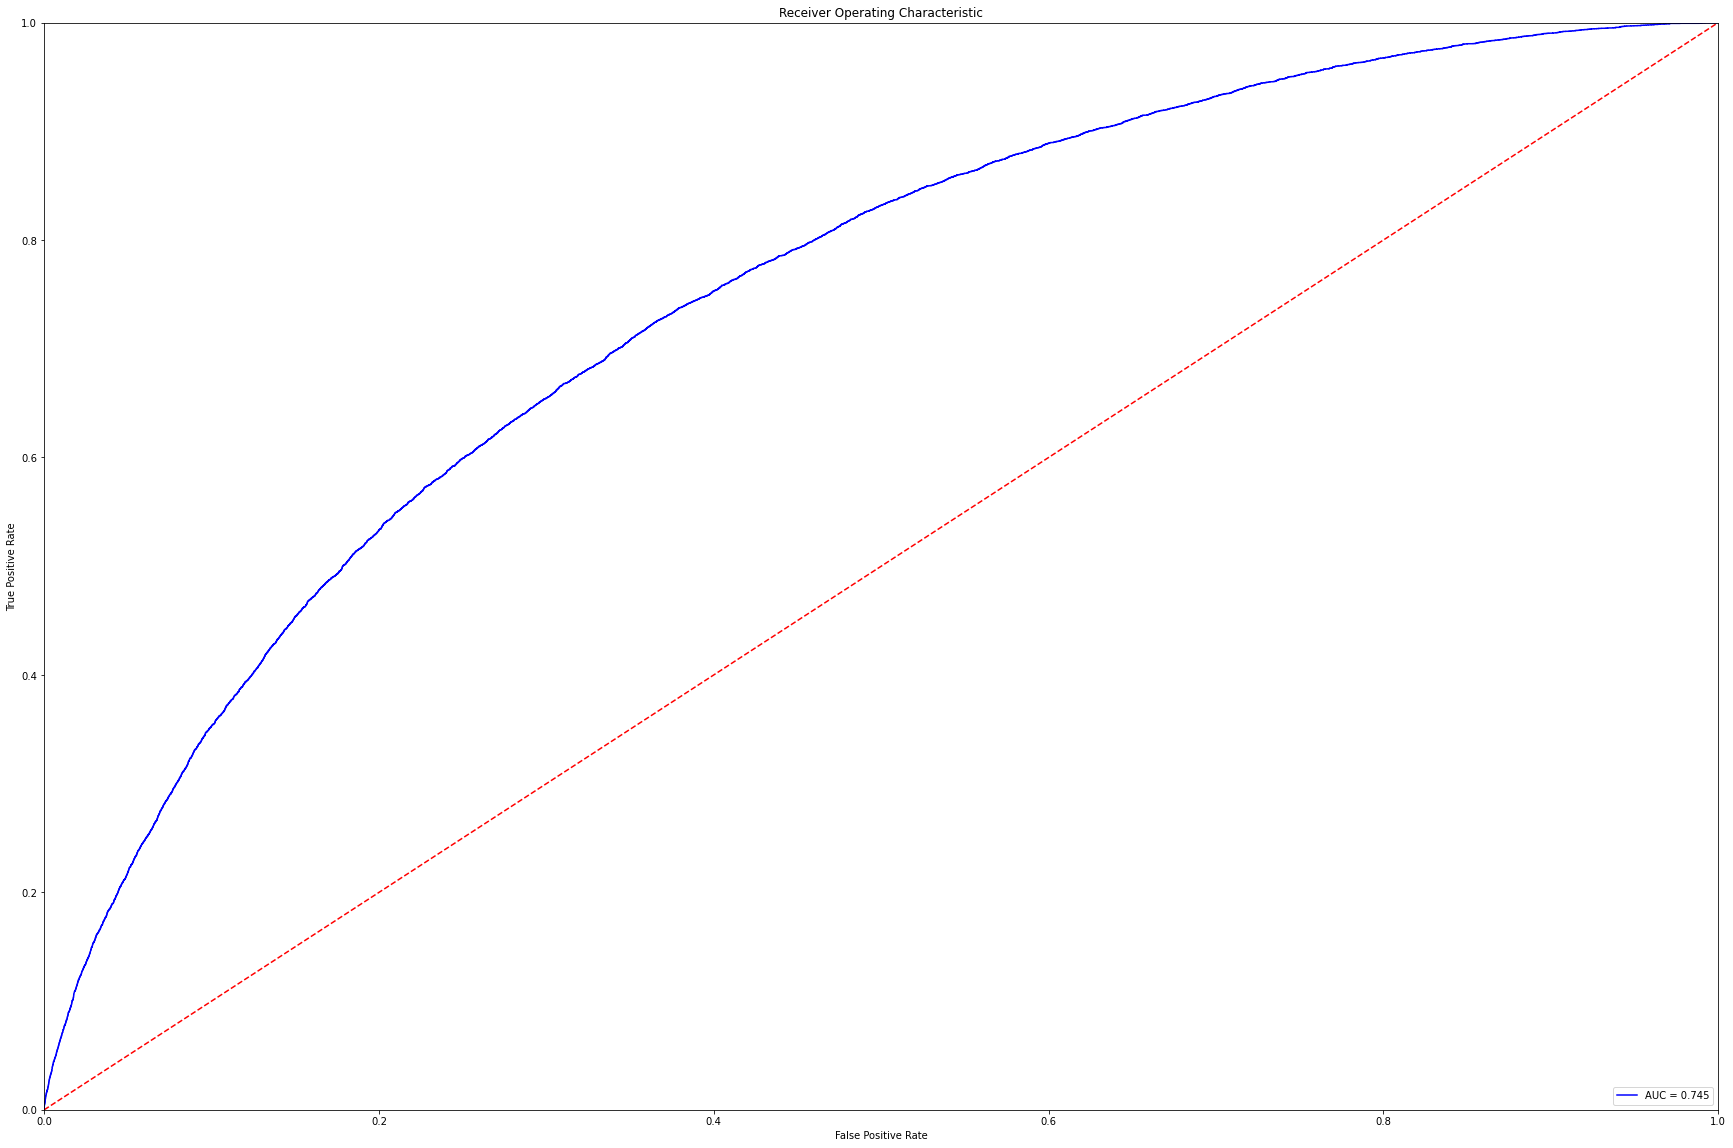

In [541]:
# method I: plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [542]:
y_pred_prob = model.predict_proba(X_test)[:,1]


submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)